# Stock price prediction

In [0]:
# Stock price prediction

In [0]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
from datetime import timedelta

In [559]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

start = datetime.datetime(2012, 9, 1)
end = datetime.datetime(2019, 9, 10)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-09-04,96.448570,94.928574,95.108574,96.424286,91973000.0,84.512062
2012-09-05,96.621429,95.657143,96.510002,95.747147,84093800.0,83.918564
2012-09-06,96.898575,95.828575,96.167145,96.610001,97799100.0,84.674820
2012-09-07,97.497147,96.538574,96.864288,97.205711,82416600.0,85.196938
2012-09-10,97.612854,94.585716,97.207146,94.677139,121999500.0,82.980743


Rolling Mean:

In [560]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.head()

Date
2012-09-04   NaN
2012-09-05   NaN
2012-09-06   NaN
2012-09-07   NaN
2012-09-10   NaN
Name: Adj Close, dtype: float64

This will calculate the Moving Average for the last 100 windows (100 days) of stocks closing price and take the average for each of the window’s moving average. As you could see, The Moving Average steadily rises over the window and does not follow the jagged line of stocks price chart. For better understanding, let’s plot it out with Matplotlib. We will overlay the Moving Average with our Stocks Price Chart.

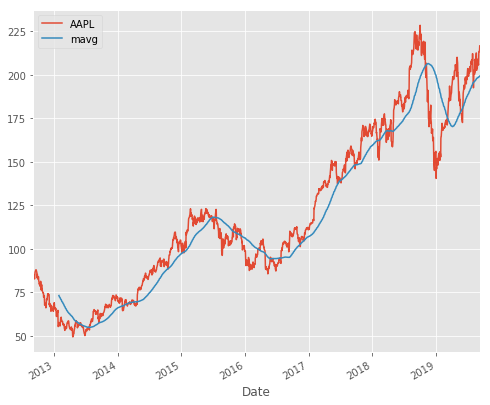

In [561]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import math

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

The Moving Average makes the line smooth and showcase the increasing or decreasing trend of stocks price. In this chart, the Moving Average showcases increasing trend the upturn or downturn of stocks price. Logically, you should buy when the stocks are experiencing downturn and sell when the stocks are experiencing upturn.

### Return Deviation — to determine risk and return

*Expected Return measures the mean, or expected value, of the probability distribution of investment returns. The expected return of a portfolio is calculated by multiplying the weight of each asset by its expected return and adding the values for each investment* — Investopedia.


Based on the formula, we could plot our returns as following.

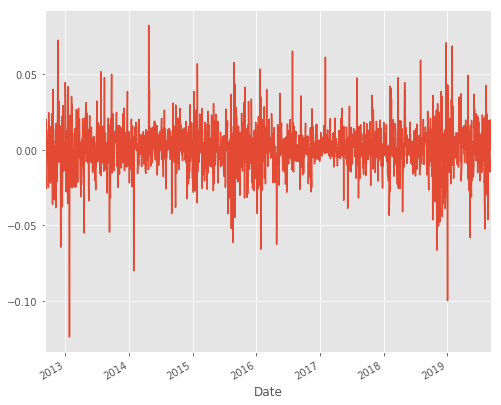

In [562]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

### Competitor stock

In [563]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.head()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2012-09-04,84.512062,15.570409,339.248413,151.246048,25.652683
2012-09-05,83.918564,15.676688,339.089020,151.634781,25.652683
2012-09-06,84.674820,16.177736,348.394135,154.791275,26.463032
2012-09-07,85.196938,16.390303,351.756531,155.102173,26.125389
2012-09-10,82.980743,16.306791,349.076569,156.229538,25.931242


### Correlation Analysis — Does one competitor affect others?
We can analyse the competition by running the percentage change and correlation function in pandas. Percentage change will find how much the price changes compared to the previous day which defines returns. Knowing the correlation will help us see whether the returns are affected by other stocks’ returns

In [564]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.259527,0.422124,0.337653,0.443848
GE,0.259527,1.000000,0.272994,0.368006,0.269838
GOOG,0.422124,0.272994,1.000000,0.379659,0.564356
IBM,0.337653,0.368006,0.379659,1.000000,0.430707
MSFT,0.443848,0.269838,0.564356,0.430707,1.000000


Return distributions of *Apple* and GE

Text(0, 0.5, 'Returns GE')

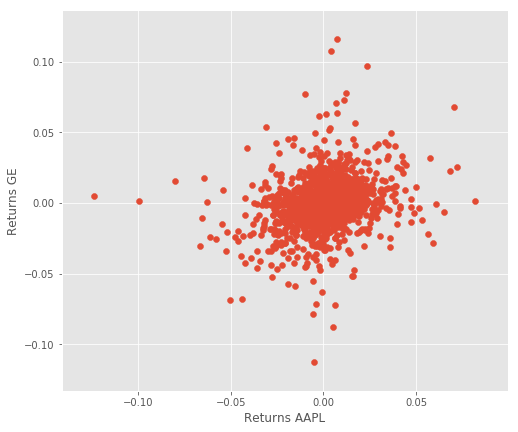

In [565]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

We can see here that there are slight positive correlations among GE returns and Apple returns. It seems like that the higher the Apple returns, the higher GE returns as well for most cases.

Let us further improve our analysis by plotting the scatter_matrix to visualize possible correlations among competing stocks. At the diagonal point, we will run Kernel Density Estimate (KDE). KDE is a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample. It helps generate estimations of the overall distributions.


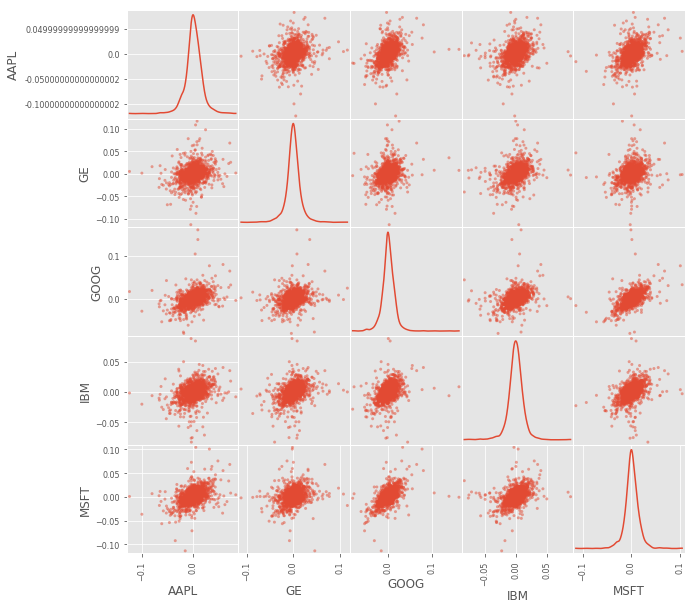

In [566]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

From here we could see most of the distributions among stocks which approximately positive correlations.
To prove the positive correlations, we will use heat maps to visualize the correlation ranges among the competing stocks. Notice that the lighter the color, the more correlated the two stocks are.

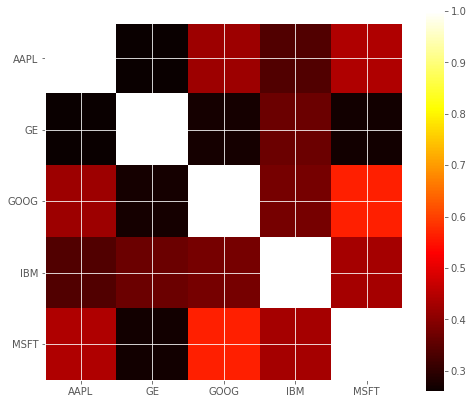

In [567]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

From the Scatter Matrix and Heatmap, we can find great correlations among the competing stocks. However, this might not show causality, and could just show the trend in the technology industry rather than show how competing stocks affect each other.

### Stocks Returns Rate and Risk
Apart from correlation, we also analyse each stock’s risks and returns. In this case we are extracting the average of returns (Return Rate) and the standard deviation of returns (Risk).

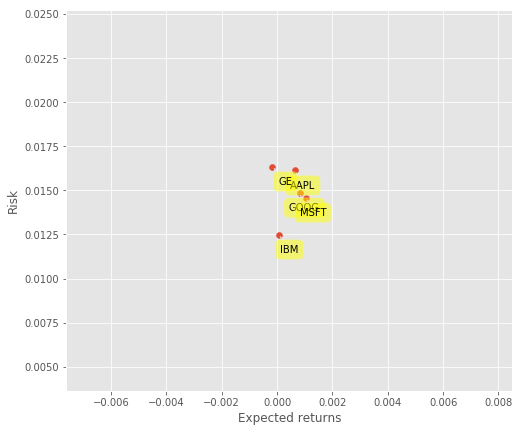

In [568]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

Now you could view this neat chart of risk and return comparisons for competing stocks. Logically, you would like to minimize the risk and maximize returns. Therefore, you would want to draw the line for your risk-return tolerance (The red line). You would then create the rules to buy those stocks under the red line (MSFT, GE, and IBM) and sell those stocks above the red line (AAPL and GOOG). This red line showcases your expected value threshold and your baseline for buy/sell decision.

## Predicting stock price

###Feature Engineering
We will use these three machine learning models to predict our stocks: Simple Linear Analysis, Quadratic Discriminant Analysis (QDA), and K Nearest Neighbor (KNN). But first, let us engineer some features: High Low Percentage and Percentage Change.

In [569]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-09-04,209.190002,19188100.0,1.032549,0.383897
2019-09-05,213.279999,23913700.0,1.153417,0.603773
2019-09-06,213.259995,19362300.0,0.895622,-0.369077
2019-09-09,214.169998,27309400.0,2.507352,-0.311859
2019-09-10,216.699997,31777900.0,2.339636,1.327970


### Pre-processing & Cross Validation
We will clean up and process the data using the following steps before putting them into the prediction models:
1. Drop missing value
2. Separating the label here, we want to predict the AdjClose
3. Scale the X so that everyone can have the same distribution for linear regression
4. Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
5. Separate label and identify it as y
6. Separation of training and testing of model by cross validation train test split

Please refer the preparation codes below.

In [0]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

### Making model

In [0]:
import math
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing, svm

### Simple Linear Analysis & Quadratic Discriminant Analysis

Simple Linear Analysis shows a linear relationship between two or more variables. When we draw this relationship within two variables, we get a straight line. Quadratic Discriminant Analysis would be similar to Simple Linear Analysis, except that the model allowed polynomial (e.g: x squared) and would produce curves.

Linear Regression predicts dependent variables (y) as the outputs given independent variables (x) as the inputs. During the plotting, this will give us a straight line as shown below:


In [572]:
df_work = df
df_train,df_test = train_test_split(df_work,train_size=0.8,random_state=42,shuffle=False)
df_train.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-09-04,96.448570,94.928574,95.108574,96.424286,91973000.0,84.512062
2012-09-05,96.621429,95.657143,96.510002,95.747147,84093800.0,83.918564
2012-09-06,96.898575,95.828575,96.167145,96.610001,97799100.0,84.674820
2012-09-07,97.497147,96.538574,96.864288,97.205711,82416600.0,85.196938
2012-09-10,97.612854,94.585716,97.207146,94.677139,121999500.0,82.980743


## Quadratic, linear, lasso and ridge



---



## Predicting

In [577]:
df_work = df
df_train,df_test = train_test_split(df_work,train_size=0.8,random_state=42,shuffle=False)
df_train.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-09-04,96.448570,94.928574,95.108574,96.424286,91973000.0,84.512062
2012-09-05,96.621429,95.657143,96.510002,95.747147,84093800.0,83.918564
2012-09-06,96.898575,95.828575,96.167145,96.610001,97799100.0,84.674820
2012-09-07,97.497147,96.538574,96.864288,97.205711,82416600.0,85.196938
2012-09-10,97.612854,94.585716,97.207146,94.677139,121999500.0,82.980743


In [0]:
y = df_train['Adj Close']
X = df_train.drop(columns=['Adj Close'])

## Linear regression

Linear Model trained with L1 prior as regularizer (aka the Lasso)

The optimization objective for Lasso is:


(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1


Technically the Lasso model is optimizing the same objective function as the Elastic Net with l1_ratio=1.0 (no L2 penalty).

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [0]:
lin_reg = LinearRegression()
lin_reg.fit(X,y);

In [581]:
y_pred = lin_reg.predict(X) 
score = mean_squared_error(y,y_pred)
np.sqrt(score)

1.5425044408520623

In [582]:
df_train['forecast'] = y_pred # Creates a new column in the dataframe named forecast


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


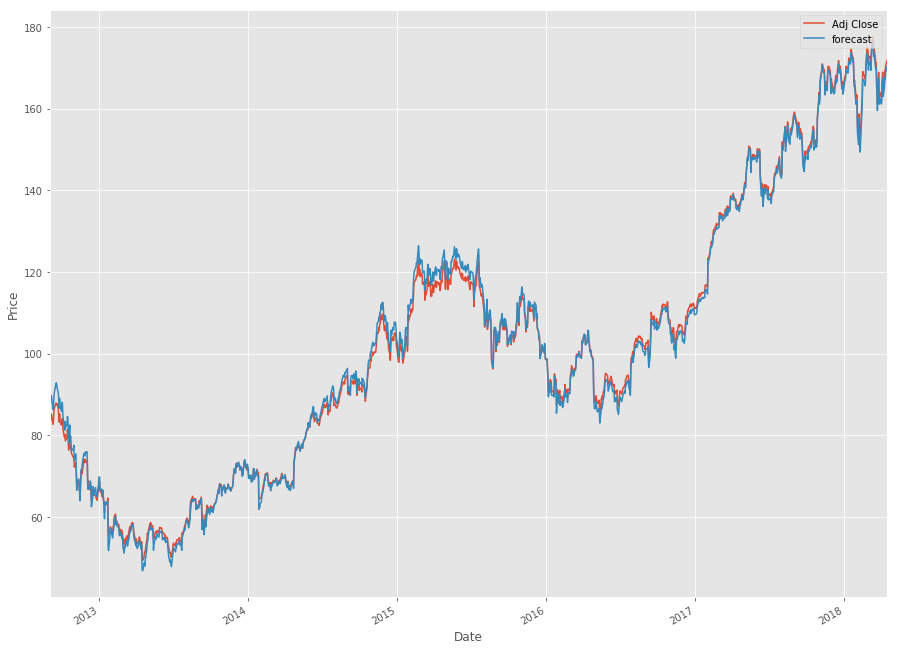

In [583]:
df_train['Adj Close'].plot(figsize=(15,12))
df_train['forecast'].plot(figsize=(15,12))
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [0]:
def plot_graph(self):
    df_train['forecast'] = self
    df_train['Adj Close'].plot(figsize=(14,8),)
    df_train['forecast'].plot(figsize=(14,8),)
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()   
  
def cross_val(self):
    scores = cross_val_score(self, X,y,scoring='neg_mean_squared_error',cv=10)
    rmse_cross_val = np.sqrt(-scores)
    
    
    print('Scores: ',-scores)
    print("Mean: ", -scores.mean())
    print("Standard Deviation: ", scores.std())

In [585]:
cross_val(lin_reg)

Scores:  [5.68617159 3.02884028 0.42891283 2.82905917 9.35644642 1.95755169
 2.43708766 2.57809801 1.18665784 5.66481649]
Mean:  3.5153641980683714
Standard Deviation:  2.5214181503014284


Mean error is : **3.5**
Standard deviation: **2.5**

## Lasso regression


Linear Model trained with L1 prior as regularizer (aka the Lasso)

The optimization objective for Lasso is:


(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1


Technically the Lasso model is optimizing the same objective function as the Elastic Net with l1_ratio=1.0 (no L2 penalty).

In [586]:
lass_reg = Lasso(alpha=0.55,random_state=42)
lass_reg.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341.95892067347586, tolerance: 152.73080385902833
  positive)


Lasso(alpha=0.55, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
y_pred_lass = lass_reg.predict(X)


In [588]:
mse_lass = mean_squared_error(y,y_pred_lass)
rmse_lass = np.sqrt(mse_lass)
rmse_lass

1.618559146605074

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


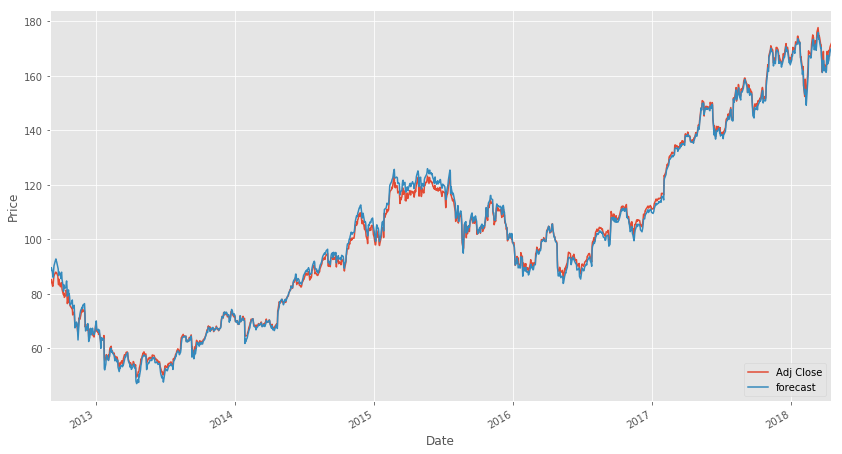

In [589]:
plot_graph(y_pred_lass)


In [590]:
cross_val(lass_reg)

Scores:  [ 5.62706497  3.0879051   0.53227758  2.82311261 10.03702595  2.46843936
  2.49102192  2.87429839  1.2575569   6.26645156]
Mean:  3.7465154326854218
Standard Deviation:  2.6690869618224644


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324.6525798754592, tolerance: 133.07304300709086
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253.39873481028644, tolerance: 121.21719664106523
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296.5089771857097, tolerance: 136.23519081440614
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 332.86688157

Mean error is : **3.7**
Standard deviation: **2.6**

## Ridge regression


Linear least squares with l2 regularization. Minimizes the objective function:

||y - Xw||^2_2 + alpha * ||w||^2_2


This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. Also known as Ridge Regression or Tikhonov regularization. This estimator has built-in support for multi-variate regression (i.e., when y is a 2d-array of shape [n_samples, n_targets]).

In [591]:
ridge = Ridge(random_state=42)
ridge.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.57889e-17): result may not be accurate.
  overwrite_a=True).T


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='auto', tol=0.001)

In [592]:
y_pred_ridge = ridge.predict(X)
print(len(X))
print(len(y))

1412
1412


In [593]:
mse_ridge = mean_squared_error(y,y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
rmse_ridge

print(len(y_pred_ridge))
print(len(y))

1412
1412


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


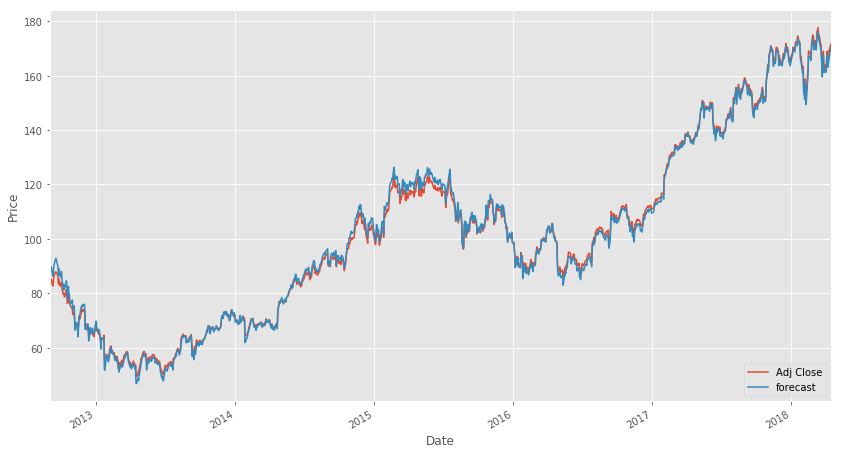

In [594]:
plot_graph(y_pred_ridge)

In [595]:
cross_val(ridge)

Scores:  [5.68586473 3.02855151 0.42888964 2.82866909 9.35667931 1.95707875
 2.43715952 2.57828606 1.18644296 5.66312448]
Mean:  3.515074603929412
Standard Deviation:  2.5213595251333496


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.06087e-16): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.44977e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.83335e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.26449e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.09961e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarni

Mean error is : **3.5**
Standard deviation: **2.5**

## Quadratic regression

In [596]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
quad_reg = make_pipeline(PolynomialFeatures(2), Ridge())
quad_reg.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.43761e-36): result may not be accurate.
  overwrite_a=True).T


Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [0]:
y_pred_quad = quad_reg.predict(X)

In [598]:
mse_quad = mean_squared_error(y,y_pred_quad)
rmse_pred = np.sqrt(mse_quad)
rmse_pred

1.1977073938451748

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


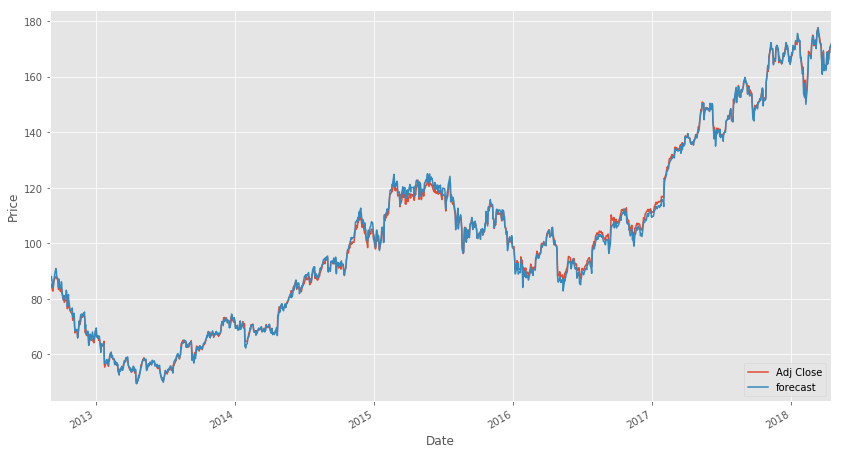

In [599]:
plot_graph(y_pred_quad)

In [600]:
cross_val(quad_reg)

Scores:  [5.32157303 0.65529087 0.7339678  1.76472042 5.36776445 1.18015458
 3.23675605 4.78083576 0.6681101  1.19069319]
Mean:  2.489986625856484
Standard Deviation:  1.892192387379669


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.3693e-35): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.73882e-36): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.95603e-36): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.58893e-36): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.54629e-36): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarnin

 Mean error is : **2.4** Standard deviation: **1.8**

# Testing

Based on the models:
1. Linear regression : 
Mean error is : **3.5**
Standard deviation: **2.5**
2. Lasso regression : 
Mean error is : **3.7**
Standard deviation: **2.6**
3. Ridge regression :
Mean error is : **3.5**
Standard deviation: **2.5**
4. Quadratic regression : 
Mean error is : **2.4**
Standard deviation: **1.8**


In [0]:
y_test = df_test['Adj Close']
X_test = df_test.drop(columns=['Adj Close'])

In [602]:
y_test_pred = ridge.predict(X_test)
print(len(X_test))
print(len(y_test))

353
353


In [603]:
final_mse=mean_squared_error(y_test, y_test_pred)
final_rmse=np.sqrt(final_mse)

final_rmse

3.316671376840653

In [0]:
def plot_graph_test(self):
    df_test['forecast'] = self
    df_test['Adj Close'].plot(figsize=(14,8),)
    df_test['forecast'].plot(figsize=(14,8),)
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


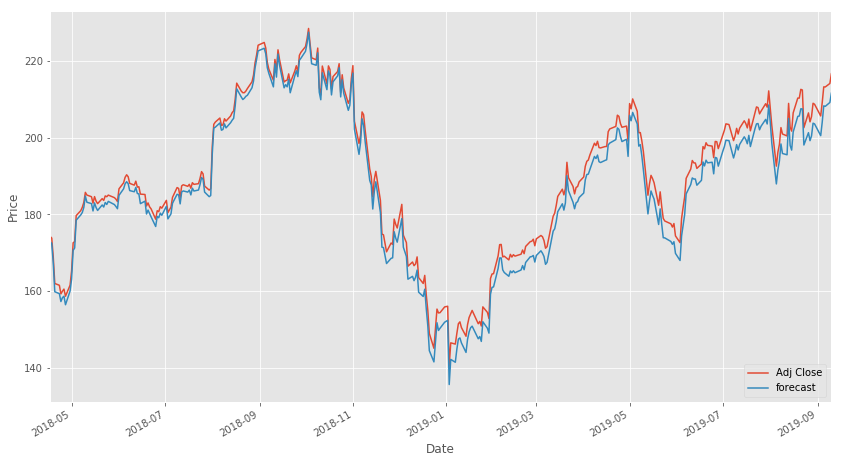

In [605]:
plot_graph_test(y_test_pred)

In [606]:
y_test = df_test['Adj Close']
X_test = df_test.drop(columns=['Adj Close'])
print(len(X_test))
print(len(y_test))

353
353


In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
quad_reg = make_pipeline(PolynomialFeatures(2), Ridge())
quad_reg.fit(X_test,y_test)
y_test_pred = quad_reg.predict(X_test)

In [608]:
final_mse=mean_squared_error(y_test,y_test_pred)
final_rmse=np.sqrt(final_mse)

final_rmse

1.1524312328414998

In [0]:
def plot_graph_test(self):
    df_test['forecast'] = self
    df_test['Adj Close'].plot(figsize=(14,8),)
    df_test['forecast'].plot(figsize=(14,8),)
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


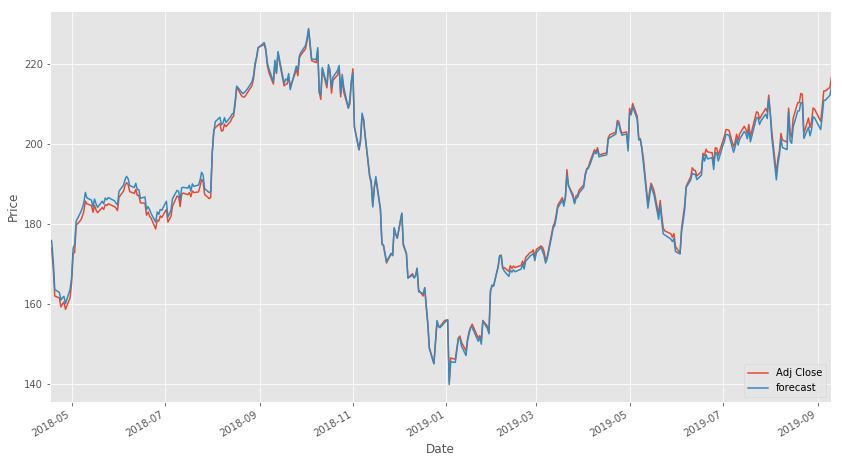

In [610]:
plot_graph_test(y_test_pred)



---





---

